In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [4]:
# ".." means to go back a direcetory
data = pd.read_csv('../data/data_preprocessed.csv').set_index('CUST_ID') # read data

In [31]:
# Defining Parameters

# define min_points
MinPts = len(data.columns)*2 # MinPts should follow attributes*2

# define epsilon
eps = 0.1

In [32]:
class dbscan_model:
    def __init__ (self,data):
        self.data = data
        
    def dbscan_model(self, eps, min_samples):
        """
        Function to run DBSCAN

        Args:
            eps (float): epsilon
            min_samples (int): minimum samples

        Returns:
            labelled_data (pandas dataframe): dataframe with labels
            self.labels (array): array of labels
        """

        X = self.data.values
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        self.labels = db.labels_
        
        n_clusters_ = len(set(self.labels)) - (1 if -1 in self.labels else 0)
        n_noise_ = list(self.labels).count(-1)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, self.labels))

        # adding cluster labels back to dataframe
        labelled_data = self.data.copy() # copy dataframe
        labelled_data['cluster'] = self.labels # add cluster labels back to standardised and pca df
        return labelled_data, self.labels

    def search_optimal_minpts (self, minpts):
        """
        Function to find optimal MinPts

        Args:
            minpts (int): minimum points

        Returns:
            distance (float): optimal epsilon value

        """       

        # Calculate average distance between each point in the data set and its nearest {MinPts} neighbours
        neigh = NearestNeighbors(n_neighbors=minpts) # using n_neighbours equivalent to minimum samples
        nbrs = neigh.fit(self.data)
        distances, indices = nbrs.kneighbors(self.data)

        # Sort distance values by ascending value and plot
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        i = np.arange(len(distances))

        # Find the optimal MinPts
        kn = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
        kn.plot_knee();
        plt.title('K-distance Graph',fontsize=20)
        plt.xlabel('Data Points sorted by distance',fontsize=14)
        plt.ylabel('Epsilon',fontsize=14)

        print(f'Optimal MinPts: {kn.knee}')
        print(f'Optimal Epsilon: {distances[kn.knee]}')
        
        return distances[kn.knee]

    def plot_dbscan(self):
        """ Function to plot DBSCAN """
        plt.figure(figsize=(10,7))
        plt.scatter(self.data['PC1'], self.data['PC2'], c=self.labels, cmap='rainbow')
        plt.title('DBSCAN')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()

In [33]:
dbscan_model = dbscan_model(data)
cluster_labels, labels = dbscan_model.dbscan_model(eps, MinPts)

Estimated number of clusters: 120
Estimated number of noise points: 2355
Silhouette Coefficient: -0.433


In [28]:
cluster_labels.cluster.value_counts()

-1      2355
 0      1134
 6       102
 7       102
 5        59
        ... 
 80        4
 101       4
 115       4
 109       4
 45        3
Name: cluster, Length: 121, dtype: int64

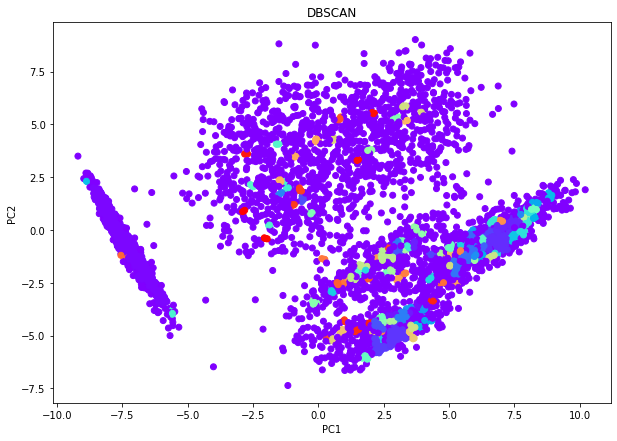

In [20]:
dbscan_model.plot_dbscan()

Optimal MinPts: 4156
Optimal Epsilon: 0.15623159316074164


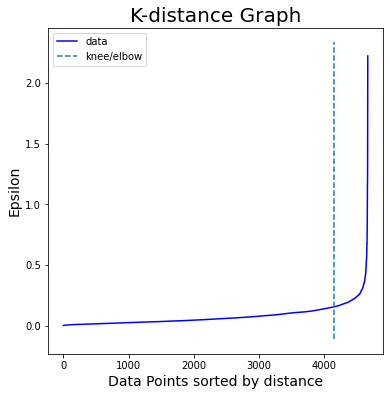

In [21]:
optimal_eps = dbscan_model.search_optimal_minpts(MinPts)

Looks like the optimal epsilon value is 0.156. Iterations of the DBSCAN model should use this optimal epsilon value during the clustering process.

Let's instantiate a new model with this new value.

In [8]:
optimal_cluster_labels, optimal_labels = dbscan_model.dbscan_model(optimal_eps, MinPts)

Estimated number of clusters: 131
Estimated number of noise points: 1237
Silhouette Coefficient: -0.189


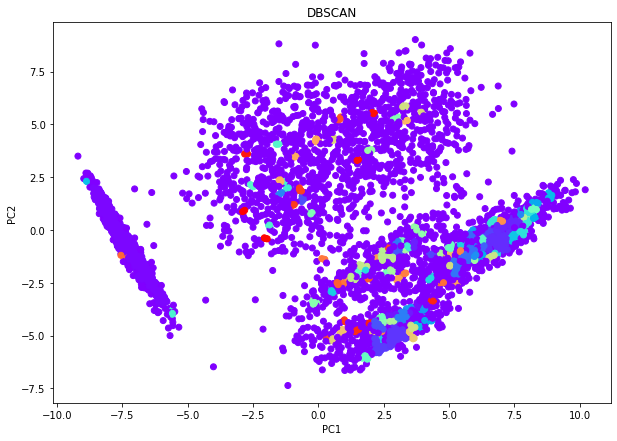

In [10]:
dbscan_model.plot_dbscan()

The silhouette coefficient improved but its still a negative number. 

DBSCAN might not be a suitable model to perform clustering on this dataset.